# CNN from scratch

In this notebook we present the experiments made to obtain our from-scratch CNN architecture.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PieTempesti98/CNNMalariaDetector/blob/master/cnn_from_scratch.ipynb)

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras as ks
from sklearn import metrics
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# global parameters
MODELS_PATH = '/content/drive/MyDrive/Colab Notebooks/cidl_project/models'
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 256
SEED = 20


In [ ]:
# set always the same seed i order to obtain reproducible results

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Preprocessing Functions
@tf.function
def scale_resize_image(image, label):
    '''
        Scale an image and resize it to the needed dimension
        :param image: the image to convert and resize
        :param label: the label of the image
        :return: a new tuple with the resized image and its label
    '''
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = tf.image.resize(image, (120, 120)) # Resizing the image to 224x224 dimention
    return (image, label)

# load the malaria dataset and split it into training, validation and test set
(train_ds, val_ds, test_ds), info = tfds.load(
        'malaria',
        as_supervised=True,
        split=['train[:80%]','train[80%:85%]', 'train[85%:]'],
        with_info=True
    )

# map the sets performing rescaling
train_ds = (
        train_ds
        .map(scale_resize_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
test_ds = (
        test_ds
        .map(scale_resize_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
val_ds = (
        val_ds
        .map(scale_resize_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete21CF25/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Model train-test-evaluation  functions
def show_train_val_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def compile_and_fit_model(model, optimizer='adam', learning_rate=0.001, epochs=30, patience=5, monitor='val_loss'):

    if optimizer == 'adam':
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        )
    if optimizer == 'rmsprop':
        model.compile(
            optimizer=tf.keras.optimizers.RMSprop(learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        )

    callbacks = [
        ks.callbacks.EarlyStopping(monitor=monitor, patience=patience),
        ks.callbacks.ModelCheckpoint(
                      filepath = MODELS_PATH + '/' + model.name + '.h5',
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
    ]

    history = model.fit(
        train_ds,
        epochs=epochs,
        shuffle=True,
        validation_data=val_ds,
        callbacks=callbacks
    )

    show_train_val_performance(history)

def evaluate_model (model):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  model = ks.models.load_model(MODELS_PATH + '/' + model.name + '.h5')
  y_score = model.predict(test_ds)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_ds], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

# Experiment 1: Basic CNN
In this test we use a simple convolutional neural network, with ReLU as activation function for the 3 convolutional layers

In [ ]:
# Basic CNN
name = 'basicCNN'
inputs = ks.Input(shape=(120,120,3))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = ks.Model(inputs=inputs, outputs=outputs, name=name)

model.summary()

Model: "basicCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       738

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


87/87 [==============================] - ETA: 0s - loss: 0.6094 - binary_accuracy: 0.6707
Epoch 1: val_loss improved from inf to 0.47723, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/basicCNN.h5
87/87 [==============================] - 29s 216ms/step - loss: 0.6094 - binary_accuracy: 0.6707 - val_loss: 0.4772 - val_binary_accuracy: 0.8041
Epoch 2/30
86/87 [============================>.] - ETA: 0s - loss: 0.3665 - binary_accuracy: 0.8733
Epoch 2: val_loss improved from 0.47723 to 0.31599, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/basicCNN.h5
87/87 [==============================] - 19s 223ms/step - loss: 0.3664 - binary_accuracy: 0.8733 - val_loss: 0.3160 - val_binary_accuracy: 0.9136
Epoch 3/30
86/87 [============================>.] - ETA: 0s - loss: 0.2739 - binary_accuracy: 0.9099
Epoch 3: val_loss improved from 0.31599 to 0.21971, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/basicCNN.h5
87/

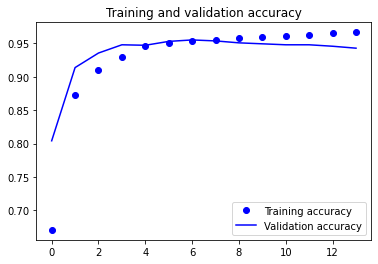

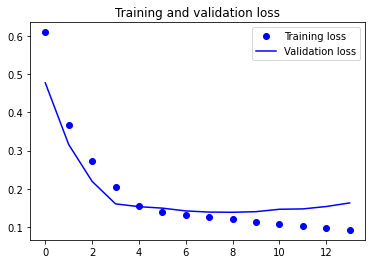

In [ ]:
compile_and_fit_model(model)

17/17 [==============================] - 3s 149ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9781    0.9204    0.9484      2086
           1     0.9235    0.9790    0.9505      2048

    accuracy                         0.9494      4134
   macro avg     0.9508    0.9497    0.9494      4134
weighted avg     0.9511    0.9494    0.9494      4134



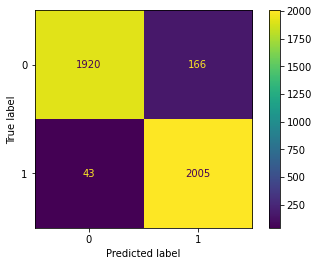

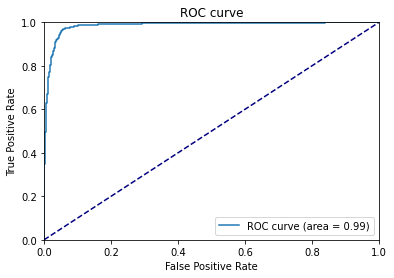

In [ ]:
evaluate_model(model)

# Experiment 2: Bigger Network
As we can see from the training and validation loss graph, the BasicCNN model reach a pretty good stability starting from the very first epochs.
We want to try to achieve even better performances, and the first step is the introduction of a new convolutional layer with 256 neurons.


In [ ]:
# Bigger CNN
name = 'biggerCNN'
inputs = ks.Input(shape=(120, 120, 3))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = ks.Model(inputs=inputs, outputs=outputs, name=name)

model.summary()

Model: "biggerCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 128)       73

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


87/87 [==============================] - ETA: 0s - loss: 0.5838 - binary_accuracy: 0.6871
Epoch 1: val_loss improved from inf to 0.34240, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/biggerCNN.h5
87/87 [==============================] - 22s 209ms/step - loss: 0.5838 - binary_accuracy: 0.6871 - val_loss: 0.3424 - val_binary_accuracy: 0.8882
Epoch 2/30
86/87 [============================>.] - ETA: 0s - loss: 0.2277 - binary_accuracy: 0.9212
Epoch 2: val_loss improved from 0.34240 to 0.18648, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/biggerCNN.h5
87/87 [==============================] - 19s 213ms/step - loss: 0.2277 - binary_accuracy: 0.9213 - val_loss: 0.1865 - val_binary_accuracy: 0.9412
Epoch 3/30
86/87 [============================>.] - ETA: 0s - loss: 0.1750 - binary_accuracy: 0.9447
Epoch 3: val_loss improved from 0.18648 to 0.17428, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/biggerCNN.h5


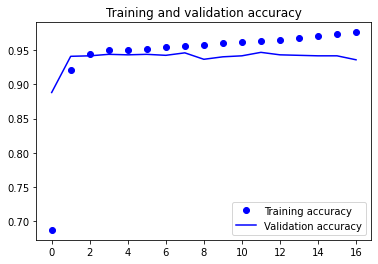

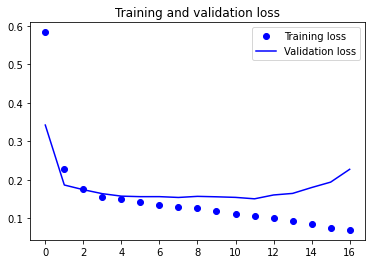

In [ ]:
compile_and_fit_model(model)

17/17 [==============================] - 3s 174ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9735    0.9147    0.9432      2086
           1     0.9181    0.9746    0.9455      2048

    accuracy                         0.9444      4134
   macro avg     0.9458    0.9446    0.9443      4134
weighted avg     0.9461    0.9444    0.9443      4134



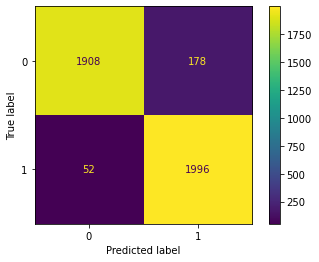

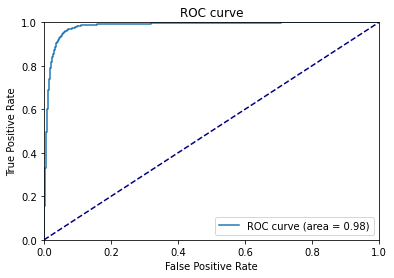

In [ ]:
evaluate_model(model)

# Experiment 3: a Dense layer
We tried to improve the bigger network results using a Dense layer with 256 neurons

In [ ]:
# 256 neuron dense layer CNN
name = '256denseCNN'
inputs = ks.Input(shape=(120,120,3))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = ks.Model(inputs=inputs, outputs=outputs, name=name)

model.summary()

Model: "256denseCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 128)       

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


86/87 [============================>.] - ETA: 0s - loss: 0.5671 - binary_accuracy: 0.6919
Epoch 1: val_loss improved from inf to 0.23160, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/256denseCNN.h5
87/87 [==============================] - 22s 224ms/step - loss: 0.5668 - binary_accuracy: 0.6921 - val_loss: 0.2316 - val_binary_accuracy: 0.9224
Epoch 2/30
86/87 [============================>.] - ETA: 0s - loss: 0.1946 - binary_accuracy: 0.9358
Epoch 2: val_loss improved from 0.23160 to 0.17203, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/256denseCNN.h5
87/87 [==============================] - 19s 212ms/step - loss: 0.1946 - binary_accuracy: 0.9357 - val_loss: 0.1720 - val_binary_accuracy: 0.9419
Epoch 3/30
86/87 [============================>.] - ETA: 0s - loss: 0.1599 - binary_accuracy: 0.9479
Epoch 3: val_loss improved from 0.17203 to 0.16423, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/256denseC

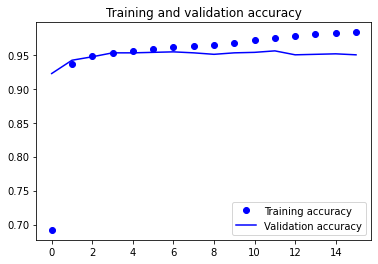

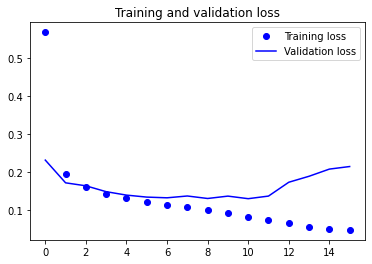

In [ ]:
compile_and_fit_model(model)

17/17 [==============================] - 3s 143ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9749    0.9319    0.9529      2086
           1     0.9336    0.9756    0.9542      2048

    accuracy                         0.9536      4134
   macro avg     0.9543    0.9538    0.9535      4134
weighted avg     0.9545    0.9536    0.9535      4134



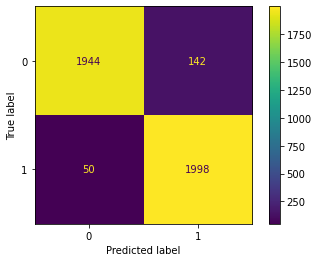

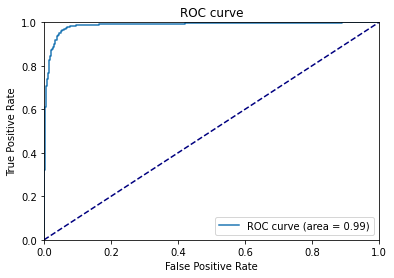

In [ ]:
evaluate_model(model)

# Experiment 4: smaller dense layer
With the dense layer the bigger network performs better than the smaller network, and now we try to reduce the number of neurons in the dense layer.

In [ ]:
# 128 neuron dense layer CNN
name = '128denseCNN'
inputs = ks.Input(shape=(120,120,3))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = ks.Model(inputs=inputs, outputs=outputs, name=name)

model.summary()

Model: "128denseCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 59, 59, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 128)       

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


86/87 [============================>.] - ETA: 0s - loss: 0.5980 - binary_accuracy: 0.6665
Epoch 1: val_loss improved from inf to 0.48180, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/128denseCNN.h5
87/87 [==============================] - 22s 216ms/step - loss: 0.5977 - binary_accuracy: 0.6667 - val_loss: 0.4818 - val_binary_accuracy: 0.7192
Epoch 2/30
86/87 [============================>.] - ETA: 0s - loss: 0.2238 - binary_accuracy: 0.9179
Epoch 2: val_loss improved from 0.48180 to 0.21118, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/128denseCNN.h5
87/87 [==============================] - 19s 213ms/step - loss: 0.2238 - binary_accuracy: 0.9179 - val_loss: 0.2112 - val_binary_accuracy: 0.9267
Epoch 3/30
86/87 [============================>.] - ETA: 0s - loss: 0.1710 - binary_accuracy: 0.9439
Epoch 3: val_loss improved from 0.21118 to 0.16730, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/128denseC

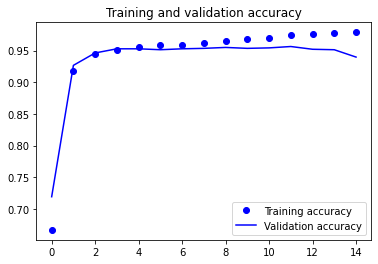

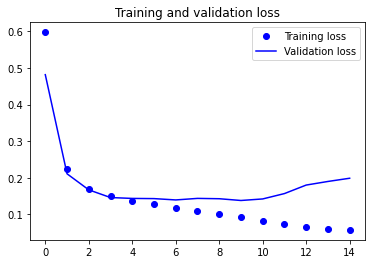

In [ ]:
compile_and_fit_model(model)

17/17 [==============================] - 3s 142ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9744    0.9314    0.9525      2086
           1     0.9332    0.9751    0.9537      2048

    accuracy                         0.9531      4134
   macro avg     0.9538    0.9533    0.9531      4134
weighted avg     0.9540    0.9531    0.9531      4134



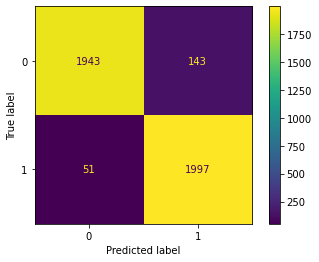

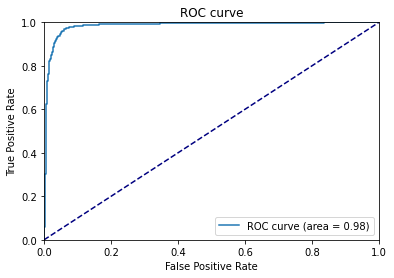

In [ ]:
evaluate_model(model)

# Experiment 5: Dense layer on top of the smaller network

The results obtained using the Dense Layer on the bigger network are really consistent, so we try to apply the 256-neurons dense layer to the smaller network.

In [ ]:
# 128 neuron dense layer on top of the smaller CNN
name = '256denseSmallCNN'
inputs = ks.Input(shape=(120,120,3))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = ks.Model(inputs=inputs, outputs=outputs, name=name)

model.summary()

Model: "256denseSmallCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 59, 59, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 26, 26, 128)  

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


86/87 [============================>.] - ETA: 0s - loss: 0.6752 - binary_accuracy: 0.5948
Epoch 1: val_loss improved from inf to 0.60168, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/256denseSmallCNN.h5
87/87 [==============================] - 20s 208ms/step - loss: 0.6752 - binary_accuracy: 0.5948 - val_loss: 0.6017 - val_binary_accuracy: 0.6887
Epoch 2/30
86/87 [============================>.] - ETA: 0s - loss: 0.5127 - binary_accuracy: 0.7629
Epoch 2: val_loss improved from 0.60168 to 0.32750, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/256denseSmallCNN.h5
87/87 [==============================] - 19s 221ms/step - loss: 0.5124 - binary_accuracy: 0.7630 - val_loss: 0.3275 - val_binary_accuracy: 0.9194
Epoch 3/30
86/87 [============================>.] - ETA: 0s - loss: 0.2142 - binary_accuracy: 0.9267
Epoch 3: val_loss improved from 0.32750 to 0.16111, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models

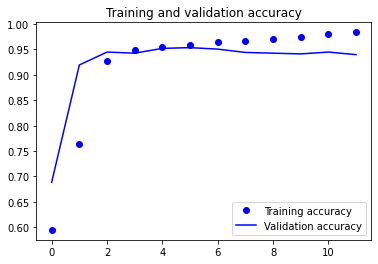

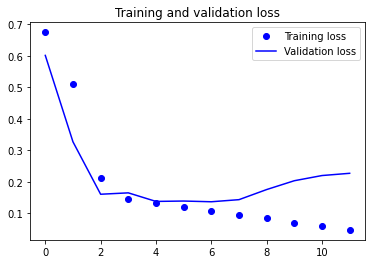

In [ ]:
compile_and_fit_model(model)

17/17 [==============================] - 2s 139ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9753    0.9262    0.9501      2086
           1     0.9285    0.9761    0.9517      2048

    accuracy                         0.9509      4134
   macro avg     0.9519    0.9511    0.9509      4134
weighted avg     0.9521    0.9509    0.9509      4134



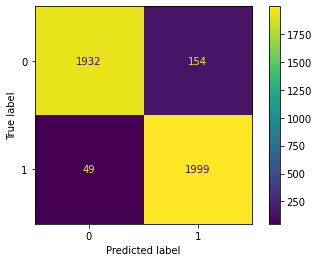

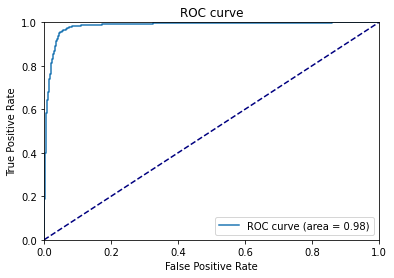

In [ ]:
evaluate_model(model)

# Conclusions

All the networks we trained perform pretty well, and they don't suffer overfitting; the network that we choose as the best is the bigger CNN with a 256-neuron Dense layer, which is the best combination of parameters in terms of accuracy and area under ROC curve.